In [2]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import numpy as np


In [3]:
Batch_size=32
Image_size=256
Channels=3
Epochs=50

In [4]:
tfdataset= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Tumor/Training",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 2870 files belonging to 4 classes.


In [5]:
class_names=tfdataset.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [6]:
for image_batch, label_batch in tfdataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 3 0 3 1 1 2 3 0 3 0 3 3 3 3 3 1 2 1 0 0 0 3 3 1 3 1 1 1 0 1 1]


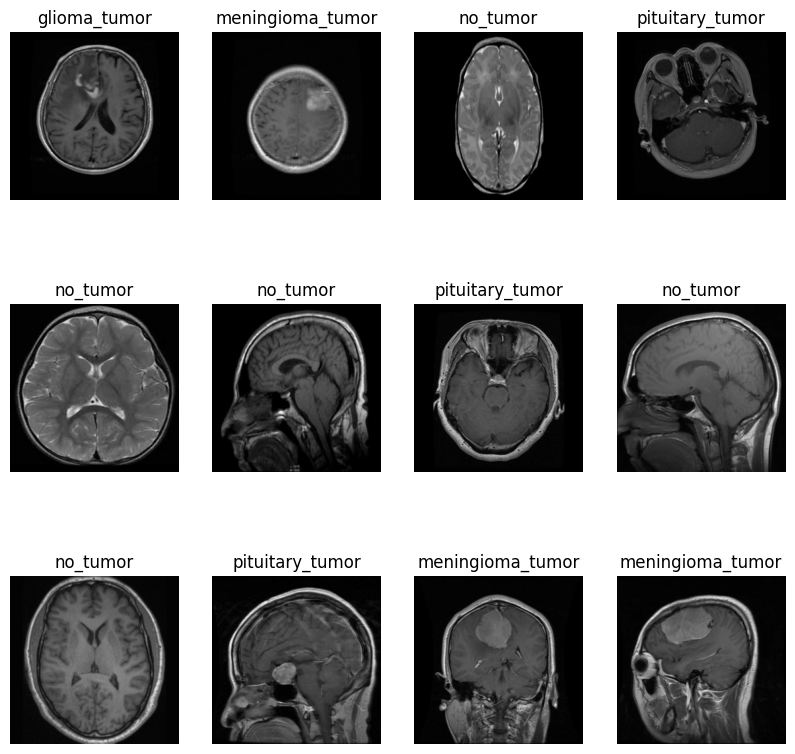

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in tfdataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

80% for Training
10% for Validation
10% for Test

In [8]:
train_size=0.8
len(tfdataset)*train_size

72.0

In [9]:
train_ds=tfdataset.take(54)
len(train_ds)

54

In [10]:
test_ds=tfdataset.skip(54)
len(test_ds)

36

In [11]:
val_size=0.1
len(tfdataset)*val_size

9.0

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

30

In [14]:
def get_dataset_partition_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
  assert(train_split+test_split+test_split)==1
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [15]:
train_ds , val_ds , test_ds =get_dataset_partition_tf(tfdataset)

In [16]:
len(train_ds)

72

In [17]:
len(val_ds)

9

In [18]:
len(test_ds)

9

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

In [21]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
]
)

In [22]:
Input_size= (Batch_size,Image_size,Image_size,Channels)
n_class=4

model= models.Sequential([
    resize_and_rescale,
    data_augmentation,


    layers.Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=Input_size, padding='SAME'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu',padding='SAME'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu',padding='SAME'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu',padding='SAME'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu',padding='SAME'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu',padding='SAME'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu',padding='SAME'),
    layers.MaxPool2D((2,2)),


    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_class, activation='softmax'),

])
model.build(input_shape=Input_size)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 64, 64, 64)         0         
 2D)                                                  

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs

)

Epoch 1/50
26/72 [=========>....................] - ETA: 4:51 - loss: 1.2857 - accuracy: 0.3882

In [ ]:
scores=model.evaluate(test_ds)
scores

In [ ]:
history

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc,label='Training Accuracy')
plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epochs),loss , label='Training Loss')
plt.plot(range(Epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
for image_batch , label_batch in test_ds.take(1):
  #for i in range(12):
   image=image_batch[0].numpy().astype("uint8")
   plt.imshow(image)
   print('Actual Label:',class_names[label_batch[0].numpy()])
   batch_prediction=model.predict(image_batch)
   print("Predicted Label", class_names[np.argmax(batch_prediction[0])])